# Preconditioning

## Classical methods

We have discussed the Jacobi preconditioner
$$ P_{\text{Jacobi}}^{-1} = D^{-1} $$
where $D$ is the diagonal of $A$.
Gauss-Seidel is
$$ P_{GS}^{-1} = (L+D)^{-1} $$
where $L$ is the (strictly) lower triangular part of $A$.  The upper triangular part may be used instead, or a symmetric form
$$ P_{SGS}^{-1} = (D+U)^{-1} D (L+D)^{-1} . $$

[*Edit after class*: fixed mistake in the above formula and added snippet below.]

#### Aside: Where does $P_{SGS}^{-1}$ come from?

Let's take the error iteration matrix for a forward sweep $I - (L+D)^{-1} A$ followed by a backward sweep $I - (D+U)^{-1}A$ and compute

\begin{align}
I - P_{SGS}^{-1} A &= \big( I - (D+U)^{-1} A \big) \big(I - (L+D)^{-1} A \big) \\
  &= I - (D+U)^{-1} A - (L+D)^{-1} A + (D+U)^{-1} A (L+D)^{-1} A \\
  &= I - \Big( (D+U)^{-1} + (L+D)^{-1} - (D+U)^{-1} A (L+D)^{-1} \Big) A \\
  &= I - \Big( (D+U)^{-1} + \underbrace{\big[I - (D+U)^{-1} A \big]}_{I - (D+U)^{-1} (D+U+L)} (L+D)^{-1} \Big) A \\
  &= I - \Big( (D+U)^{-1} - (D+U)^{-1} L (L+D)^{-1} \Big) A \\
  &= I - \Big( (D+U)^{-1} - (D+U)^{-1} \underbrace{(L+D-D) (L+D)^{-1}}_{I - D (L+D)^{-1}} \Big) A \\
  &= I - \underbrace{(D+U)^{-1} D (L+D)^{-1}}_{P_{SGS}^{-1}} A .
\end{align}

## Domain decomposition

Suppose we know how to solve problems on "subdomains", which may overlap.

![](https://upload.wikimedia.org/wikipedia/commons/a/a9/Ddm_original_logo.png)

This could be possible because they have special structure (e.g., above) or because they are small enough.  We want to use this ability to solve the global problem.

### Alternating Schwarz method

```python
bc_circle = guess()
while not converged:
    u_circle = solve(A_circle, bc_circle)
    bc_rectangle = eval(u_circle, rectangle)
    u_rectangle = solve(A_rectangle, bc_rectangle)
    bc_circle = eval(u_rectangle, circle)
```

This method was proposed in 1870 by [Hermann Schwarz](https://en.wikipedia.org/wiki/Hermann_Schwarz) as a theoretical tool, and is now called a "multiplicative" Schwarz method because the solves depend on each other.  We can see it as a generalization of Gauss-Seidel in which we solve on subdomains instead of at individual grid points.  As with Gauss-Seidel, it is difficult to expose parallelism.

### Additive Schwarz methods

The additive Schwarz method is more comparable to Jacobi, with each domain solved in parallel.  Our fundamental operation will be an embedding of each subdomain $V_i$ into the global domain $V$, which we call the **prolongation**

$$ P_i : V_i \to V $$

The transpose of prolongation, $P_i^T$, will sometimes be called **restriction**.
Let's work an example.

(21, 7)


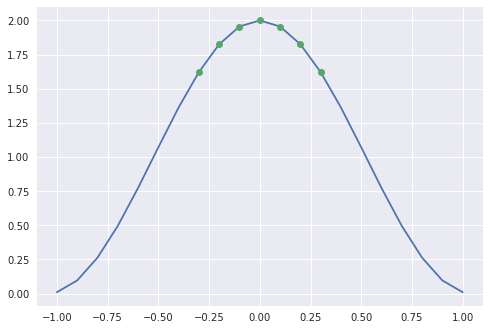

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

N = 21
x = np.linspace(-1, 1, N)
overlap = 0
domains = [(0,N//3+overlap), (N//3-overlap, 2*N//3+overlap), (2*N//3-overlap, N)]
P = []
for i, (start, end) in enumerate(domains):
    P.append(np.eye(N, end-start, -start))
u = 1 + np.cos(3*x)
plt.plot(x, u)
u1 = P[1].T @ u   # Restrict to subdomain 1
plt.plot(P[1].T @ x, u1, 'o')
print(P[1].shape)

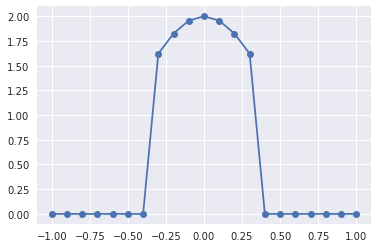

In [2]:
plt.plot(x, P[1] @ u1, 'o-');  # Prolong to global domain

In [3]:
# Define a Laplacian
A = np.eye(N)
A[1:-1] = (2*np.eye(N-2, N, 1) - np.eye(N-2, N, 0) - np.eye(N-2, N, 2)) / (N-1)**2
A[:5, :5]

array([[ 1.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [-0.0025,  0.005 , -0.0025,  0.    ,  0.    ],
       [ 0.    , -0.0025,  0.005 , -0.0025,  0.    ],
       [ 0.    ,  0.    , -0.0025,  0.005 , -0.0025],
       [ 0.    ,  0.    ,  0.    , -0.0025,  0.005 ]])

The first and last rows implement boundary conditions; the interior is the familiar centered difference method for the Laplacian.

In [4]:
A1 = P[1].T @ A @ P[1]
A1

array([[ 0.005 , -0.0025,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [-0.0025,  0.005 , -0.0025,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    , -0.0025,  0.005 , -0.0025,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    , -0.0025,  0.005 , -0.0025,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , -0.0025,  0.005 , -0.0025,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    , -0.0025,  0.005 , -0.0025],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    , -0.0025,  0.005 ]])

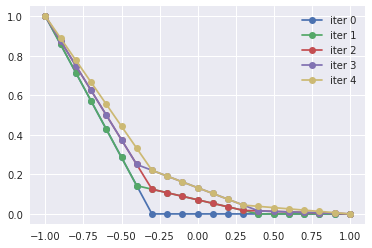

In [5]:
rhs = np.zeros_like(x)
rhs[0] = 1 # Boundary condition
u = np.zeros_like(x) # Initial guess
for iter in range(5):
    r = rhs - A @ u      # Residual
    u_next = u.copy()
    for Pi in P:
        Ai = Pi.T @ A @ Pi
        ui = np.linalg.solve(Ai, Pi.T @ r)
        u_next += Pi @ ui
    u = u_next
    plt.plot(x, u, 'o-', label=f'iter {iter}')
plt.legend();

#### Hands-on
Go back and increase `overlap` to see how it affects convergence.

### Theory

Given a linear operator $A : V \to V$, suppose we have a collection of prolongation operators $P_i : V_i \to V$.  The columns of $P_i$ are "basis functions" for the subspace $V_i$.  The Galerkin operator $A_i = P_i^T A P_i$ is the action of the original operator $A$ in the subspace.

Define the subspace projection

$$ S_i = P_i A_i^{-1} P_i^T A . $$

* $S_i$ is a projection: $S_i^2 = S_i$
* If $A$ is SPD, $S_i$ is SPD with respect to the $A$ inner product $x^T A y$
* $I - S_i$ is $A$-orthogonal to the range of $P_i$

In [6]:
S1 = P[1] @ np.linalg.inv(A1) @ P[1].T @ A
np.linalg.norm(S1 @ S1 - S1)

1.2457015262873114e-15

In [7]:
I = np.eye(*S1.shape)
np.linalg.norm(P[1].T @ A @ (I - S1))

6.9011609626021565e-18

Note, the concept of $A$-orthogonality is meaningful only when $A$ is SPD.
Does the mathematical expression $ P_i^T A (I - S_i) = 0 $ hold even when $A$ is nonsymmetric?

These projections may be applied additively

$$ I - \sum_{i=0}^n S_i, $$

multiplicatively

$$ \prod_{i=0}^n (I - S_i), $$

or in some hybrid manner, such as

$$ (I - S_0) (I - \sum_{i=1}^n S_i) . $$
In each case above, the action is expressed in terms of the error iteration operator.

### Examples

* Jacobi corresponds to the additive preconditioner with $P_i$ as the $i$th column of the identity
* Gauss-Seidel is the multiplicate preconditioner with $P_i$ as the $i$th column of the identity
* Block Jacobi corresponds to labeling "subdomains" and $P_i$ as the columns of the identity corresponding to non-overlapping subdomains
* Overlapping Schwarz corresponds to overlapping subdomains
* $P_i$ are eigenvectors of $A$
* A domain is partitioned into interior $V_{I}$ and interface $V_\Gamma$ degrees of freedom.  $P_{I}$ is embedding of the interior degrees of freedom while $P_\Gamma$ is "harmonic extension" of the interface degrees of freedom.  Consider the multiplicative combination $(I - S_\Gamma)(I - S_{I})$.

### Convergence theory

The formal convergence is beyond the scope of this course, but the following estimates are useful.  We let $h$ be the element diameter, $H$ be the subdomain diameter, and $\delta$ be the overlap, each normalized such that the global domain diameter is 1.  We express the convergence in terms of the condition number $\kappa$ for the preconditioned operator.

* (Block) Jacobi: $\delta=0$, $\kappa \sim H^{-2} H/h = (Hh)^{-1}$
* Overlapping Schwarz: $\kappa \sim H^{-2} H/\delta = (H \delta)^{-1}$
* 2-level overlapping Schwarz: $\kappa \sim H/\delta$

### Hands-on with PETSc: demonstrate these estimates

* Symmetric example: `src/snes/examples/tutorials/ex5.c`
* Nonsymmetric example: `src/snes/examples/tutorials/ex19.c`
* Compare preconditioned versus unpreconditioned norms.
* Compare BiCG versus GMRES
* Compare domain decomposition and multigrid preconditioning
 * `-pc_type asm` (Additive Schwarz)
  * `-pc_asm_type basic` (symmetric, versus `restrict`)
  * `-pc_asm_overlap 2` (increase overlap)
  * Effect of direct subdomain solver: `-sub_pc_type lu`
 * `-pc_type mg` (Geometric Multigrid)
* Use monitors:
 * `-ksp_monitor_true_residual`
 * `-ksp_monitor_singular_value`
 * `-ksp_converged_reason`
* Explain methods: `-snes_view`
* Performance info: `-log_view`

#### Examples
```
mpiexec -n 4 ./ex19 -lidvelocity 2 -snes_monitor -da_refine 5 -ksp_monitor -pc_type asm -sub_pc_type lu
```